In [1]:
import numpy as np
from utils import generate_sample, DEOptim, RandomOptim, PSOOptim, visualize_meshgrid, get_likelihood_grids, visualize_pred_meshgrid
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import plotly.express as px
import pandas as pd

In [2]:
target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)

n_dims = 2
lower_bound = -2.5, -1.5
upper_bound = +1.5, +2.5

In [3]:
de = DEOptim(visualize=False, maxiter=100, popsize=10)

In [4]:
rs = RandomOptim(maxiter=1000, visualize=False)

In [5]:
seed = np.random.RandomState(42)
part = 10
dim = 2
pso = PSOOptim(n_iters=100, n_particles=part, c1=0.5, c2=0.3, w=0.9, init_pos=(seed.rand(part, dim)*22)-11, visualize=False)

In [6]:
results_dict = {
    "optim": [],
    "n": [],
    "log_likelihood": [],
    # "MSE": []
}

In [7]:
from tqdm import tqdm

In [8]:
bar = tqdm(total=3*4*20)
for o in ["de", "rs", "pso"]:
    for n in [10, 50, 100, 500]:
        for iter in range(20):
            if o == "de":
                optim = DEOptim(visualize=False, maxiter=100, popsize=10)
            elif o == "rs":
                optim = RandomOptim(maxiter=1000, visualize=False, random_state=iter)
            else:
                optim = PSOOptim(n_iters=100, n_particles=part, c1=0.5, c2=0.3, w=0.9, init_pos=(seed.rand(part, dim)*22)-11, visualize=False)
            gpr = GaussianProcessRegressor(optimizer=optim.optimize, kernel=RBF(length_scale=(1, 1)))
            X, y = generate_sample(n, n_dims, lower_bound, upper_bound, target_func)
            gpr.fit(X.T, y[...,None])
            results_dict["optim"].append(optim.__class__.__name__)
            results_dict["n"].append(n)
            results_dict["log_likelihood"].append(gpr.log_marginal_likelihood_value_)
            bar.update(1)
            # results_dict["MSE"].append(mean_squared_error(y, gpr.predict(X.T)))

 67%|██████▋   | 160/240 [12:12<31:52, 23.90s/it]2022-08-09 16:44:25,662 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=5.32e+3
2022-08-09 16:44:26,467 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5315.411699467959, best pos: [ 1.37901812 -0.96191642]
 67%|██████▋   | 161/240 [12:12<22:21, 16.98s/it]2022-08-09 16:44:26,484 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=5.32e+3
2022-08-09 16:44:27,310 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5315.439651828215, best pos: [ 1.38020236 -0.95988206]
 68%|██████▊   | 162/240 [12:13<15:46, 12.14s/it]2022-08-09 16:44:27,323 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 10

In [9]:
df = pd.DataFrame(results_dict)

In [10]:
df

,optim,n,log_likelihood
0,DEOptim,10,-5316.674214
1,DEOptim,10,-5315.400923
2,DEOptim,10,-6532.727249
3,DEOptim,10,-5315.400923
4,DEOptim,10,-5315.400924
...,...,...,...
235,PSOOptim,500,-49514.245467
236,PSOOptim,500,-49514.156373
237,PSOOptim,500,-49514.309900
238,PSOOptim,500,-49514.267387


In [11]:
df_results_ = df.groupby(['n'], as_index=False).agg({'log_likelihood': ['mean','std']})

In [12]:
df.to_csv("data_points.csv")

In [13]:
from scipy.stats import t
df_results_["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * df_results_["log_likelihood"]["std"] + df_results_["log_likelihood"]["mean"]
df_results_["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * df_results_["log_likelihood"]["std"] + df_results_["log_likelihood"]["mean"]

2022-08-09 16:55:19,906 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


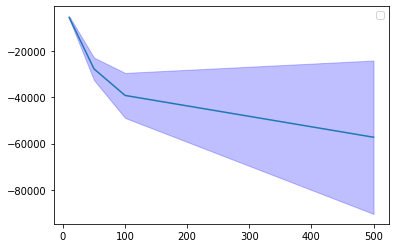

In [14]:
import matplotlib.pyplot as plt

plt.plot(df_results_["n"], df_results_["log_likelihood"]["mean"])
plt.fill_between(df_results_["n"], df_results_["conf_95_u"], df_results_["conf_95_o"], color="b", alpha=.25)
plt.legend()
plt.show();

In [15]:
std_mean_results = df.groupby(["n", "optim"], as_index=False).agg({'log_likelihood': ['mean','std']})

In [16]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
optim,DEOptim,DEOptim,DEOptim,DEOptim,DEOptim,DEOptim,DEOptim,DEOptim,DEOptim,DEOptim,...,PSOOptim,PSOOptim,PSOOptim,PSOOptim,PSOOptim,PSOOptim,PSOOptim,PSOOptim,PSOOptim,PSOOptim
n,10,10,10,10,10,10,10,10,10,10,...,500,500,500,500,500,500,500,500,500,500
log_likelihood,-5316.674214,-5315.400923,-6532.727249,-5315.400923,-5315.400924,-5315.400923,-5315.400923,-5315.400924,-5315.400923,-5315.400923,...,-49516.296327,-49524.005227,-49514.688868,-49514.505036,-49514.248114,-49514.245467,-49514.156373,-49514.3099,-49514.267387,-49514.851261


In [24]:
std_mean_results

n        optim log_likelihood              
                               mean           std
0    10      DEOptim   -5376.336635  2.721863e+02
1    10     PSOOptim   -5315.430825  6.987494e-02
2    10  RandomOptim   -5646.598619  2.196041e+02
3    50      DEOptim  -26606.716688  1.475301e-05
4    50     PSOOptim  -26607.196758  1.432417e+00
5    50  RandomOptim  -29819.710949  3.095121e+03
6   100      DEOptim  -36621.097989  1.231660e-08
7   100     PSOOptim  -36621.238391  1.401308e-01
8   100  RandomOptim  -44236.490026  5.137395e+03
9   500      DEOptim  -49520.785998  9.247917e+00
10  500     PSOOptim  -49516.607747  5.659101e+00
11  500  RandomOptim  -72632.681200  2.009649e+04

In [34]:
DE_results = std_mean_results.loc[std_mean_results['optim'] == "DEOptim"]
RS_results = std_mean_results.loc[std_mean_results['optim'] == "RandomOptim"]
PSO_results = std_mean_results.loc[std_mean_results['optim'] == "PSOOptim"]

In [35]:
from scipy.stats import t
DE_results["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * DE_results["log_likelihood"]["std"] + DE_results["log_likelihood"]["mean"]
DE_results["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * DE_results["log_likelihood"]["std"] + DE_results["log_likelihood"]["mean"]

RS_results["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * RS_results["log_likelihood"]["std"] + RS_results["log_likelihood"]["mean"]
RS_results["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * RS_results["log_likelihood"]["std"] + RS_results["log_likelihood"]["mean"]

PSO_results["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * PSO_results["log_likelihood"]["std"] + PSO_results["log_likelihood"]["mean"]
PSO_results["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * PSO_results["log_likelihood"]["std"] + PSO_results["log_likelihood"]["mean"]

C:\Users\tzehl\AppData\Local\Temp\ipykernel_440\338358154.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_results["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * DE_results["log_likelihood"]["std"] + DE_results["log_likelihood"]["mean"]
C:\Users\tzehl\AppData\Local\Temp\ipykernel_440\338358154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_results["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * DE_results["log_likelihood"]["std"] + DE_results["log_likelihood"]["mean"]
C:\Users\tzehl\AppData\Local\Temp\i

In [36]:
RS_results

n        optim log_likelihood                   conf_95_o      conf_95_u
                               mean           std                             
2    10  RandomOptim   -5646.598619    219.604141  -5186.961870   -6106.235368
5    50  RandomOptim  -29819.710949   3095.121393 -23341.547422  -36297.874476
8   100  RandomOptim  -44236.490026   5137.395390 -33483.797897  -54989.182155
11  500  RandomOptim  -72632.681200  20096.489388 -30570.245502 -114695.116898

In [37]:
std_mean_results

n        optim log_likelihood              
                               mean           std
0    10      DEOptim   -5376.336635  2.721863e+02
1    10     PSOOptim   -5315.430825  6.987494e-02
2    10  RandomOptim   -5646.598619  2.196041e+02
3    50      DEOptim  -26606.716688  1.475301e-05
4    50     PSOOptim  -26607.196758  1.432417e+00
5    50  RandomOptim  -29819.710949  3.095121e+03
6   100      DEOptim  -36621.097989  1.231660e-08
7   100     PSOOptim  -36621.238391  1.401308e-01
8   100  RandomOptim  -44236.490026  5.137395e+03
9   500      DEOptim  -49520.785998  9.247917e+00
10  500     PSOOptim  -49516.607747  5.659101e+00
11  500  RandomOptim  -72632.681200  2.009649e+04

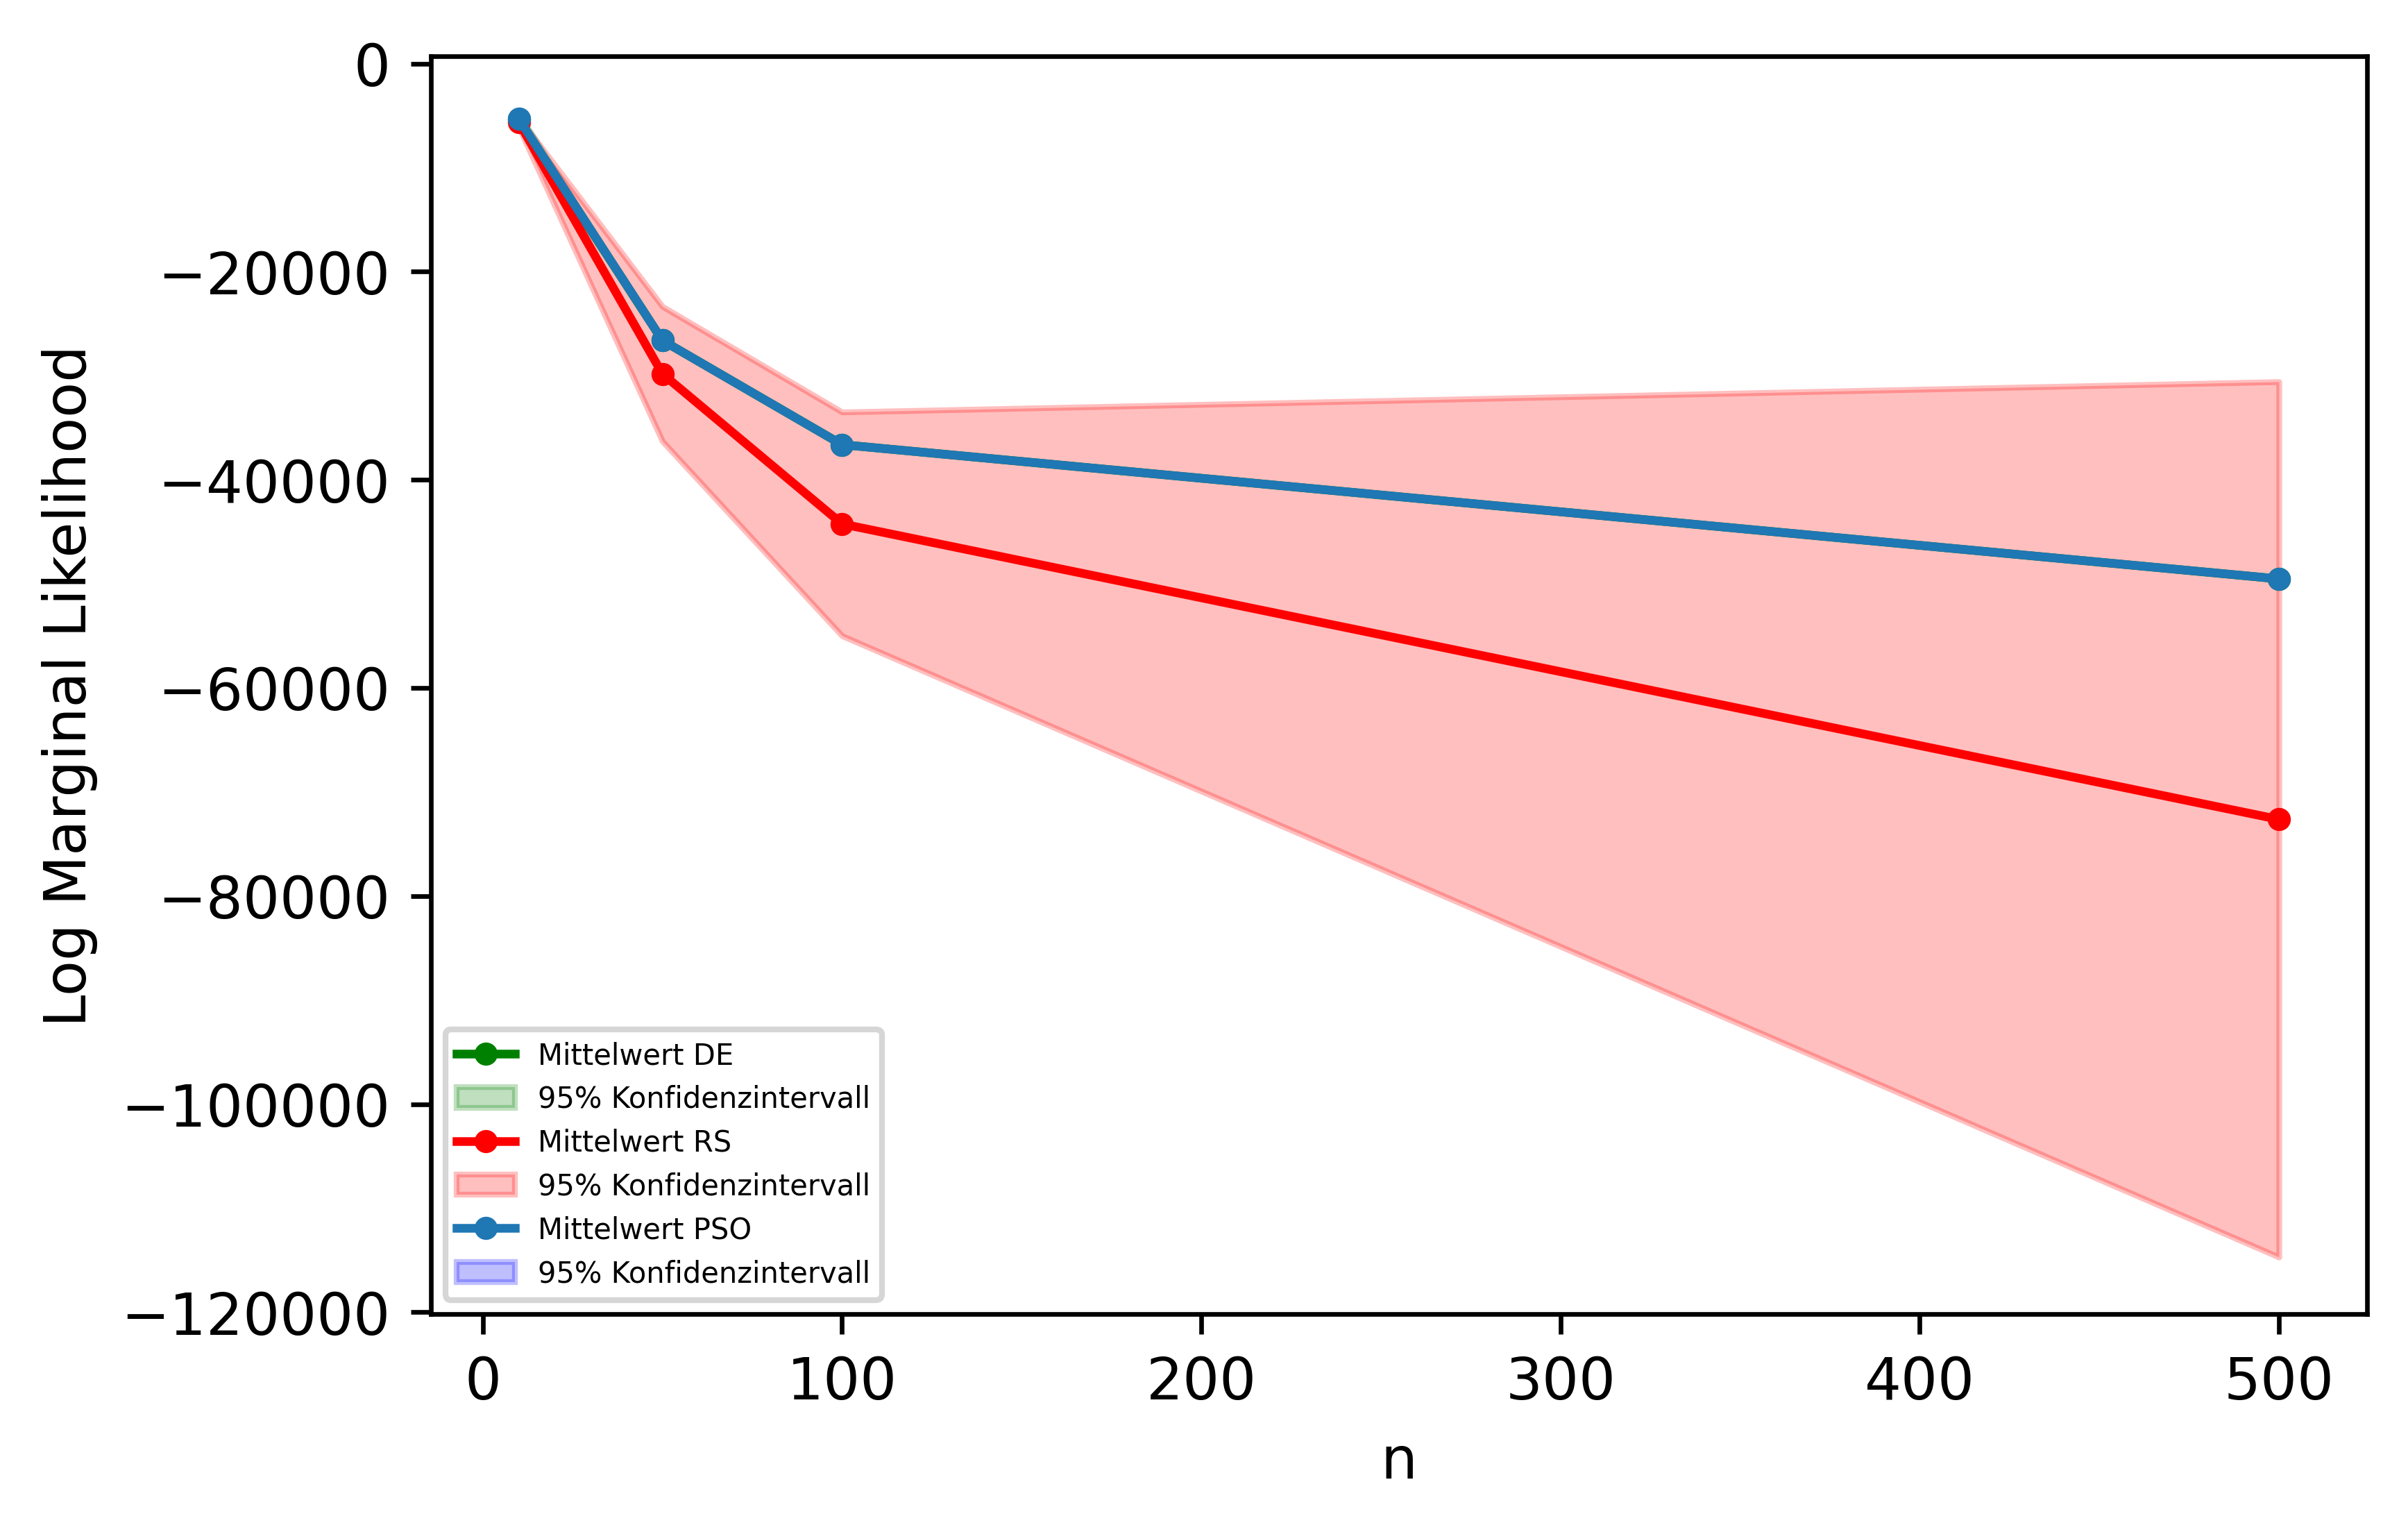

In [38]:
plt.figure(dpi=600)
plt.plot(DE_results["n"], DE_results["log_likelihood"]["mean"], marker="o", markersize=3, color="g", label="Mittelwert DE")
plt.fill_between(DE_results["n"], DE_results["conf_95_u"], DE_results["conf_95_o"], color="g", alpha=.25, label="95% Konfidenzintervall")

plt.plot(RS_results["n"], RS_results["log_likelihood"]["mean"], marker="o", markersize=3, color="r", label="Mittelwert RS")
plt.fill_between(RS_results["n"], RS_results["conf_95_u"], RS_results["conf_95_o"], color="r", alpha=.25, label="95% Konfidenzintervall")

plt.plot(PSO_results["n"], PSO_results["log_likelihood"]["mean"], marker="o", markersize=3, label="Mittelwert PSO")
plt.fill_between(PSO_results["n"], PSO_results["conf_95_u"], PSO_results["conf_95_o"], color="b", alpha=.25, label="95% Konfidenzintervall")

plt.ylabel("Log Marginal Likelihood")
plt.xlabel("n")
plt.legend(fontsize=5, loc='lower left')